[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slayoo/seattle-2026-workshop/blob/main/part_4_CCN_complete.ipynb)

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils mendeleev pint PySDM

# hacking aerosol-cloud μ-physics modeling concepts in Python
### (mini-workshop @Uni. Washington Seattle, Jan 2026)

### Part 2: CCN activation model from scratch in Python (unit handling with Pint)

notebook authors (alphabetically): 
- Sylwester Arabas
- Daria Klimaszewska
- Emma Ware

This notebook implements a basic adiabatic air parcel model with moving-sectional (=super-droplet) aerosol-cloud spectrum description.
For reference on the employed theory and equations, see e.g. [Arabas & Shima 2017](https://doi.org/10.5194/npg-24-535-2017) (where the model is applied with a monodisperse droplet population, here a polydisperse case is resolved assuming constant-multiplicity sampling).

TODO: describe initial spectrum theory

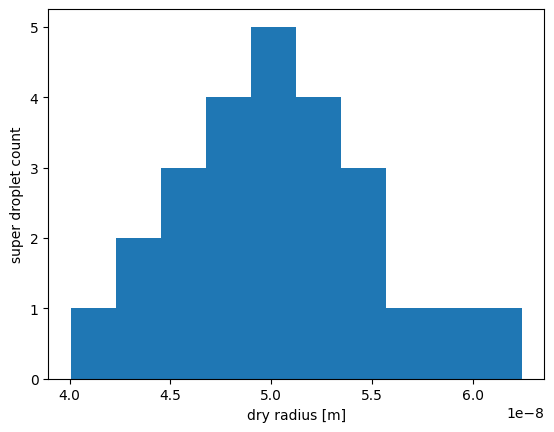

In [1]:
import numpy as np, scipy
from matplotlib import pyplot

σ_geom = 1.1
r_dry_median_metre = .05e-6
n_sd = 25

dry_radii_over_metre = scipy.stats.lognorm.ppf(
    np.linspace(.01, .99, n_sd),
    np.log(σ_geom),
    0,
    r_dry_median_metre
)

pyplot.hist(dry_radii_over_metre)
pyplot.gca().set(ylabel="super droplet count", xlabel="dry radius [m]")
pyplot.show()

TODO: describe ODE system logic

In [2]:
from collections import namedtuple
make_namedtuple = lambda name, items: namedtuple(name, items.keys())(*items.values())

ix = make_namedtuple("I", {"ln_rw": slice(0,n_sd), "pd": n_sd, "T": n_sd+1, "n": n_sd + 2})
print(ix)

I(ln_rw=slice(0, 25, None), pd=25, T=26, n=27)


In [3]:
from PySDM import physics
import mendeleev

def constants():
    SI = physics.si

    y0 = [0] * ix.n
    y0[ix.pd] = 1000 * SI.hPa
    y0[ix.T] = 300 * SI.K
    y0[ix.ln_rw] = np.log(dry_radii_over_metre)  # note: better to equilibrate

    M_a = (
        0.78 * 2 * mendeleev.N.atomic_weight * SI.g / SI.mole + 
        0.21 * 2 * mendeleev.O.atomic_weight * SI.g / SI.mole + 
        0.01 * 2 * mendeleev.Ar.atomic_weight * SI.g / SI.mole
    )
    M_v = (
        1 * mendeleev.O.atomic_weight * SI.g / SI.mole + 
        2 * mendeleev.H.atomic_weight * SI.g / SI.mole
    )
    R_str = scipy.constants.R * SI.J / SI.K / SI.mole
    
    return make_namedtuple("C", {
        "R_d": R_str / M_a,
        "R_v": R_str / M_v,
        "cp_d": 1000 * SI.J / SI.kg / SI.K,
        "l_v": 45000 * SI.joule / SI.mol / M_v,
        "g": scipy.constants.g * SI.m / SI.s**2,
        "A": 1e-3 * SI.um,
        "rho_w": 1 * SI.kg / SI.litre,
        "D_eff": 2.3e-5 * SI.metre**2 / SI.s,
        "T0": scipy.constants.zero_Celsius * SI.K,

        "B80_G0": 6.112 * SI.hPa,
        "B80_G1": 17.67 * SI.dimensionless,
        "B80_G2": 243.5 * SI.K,
        
        "κ": 1.28,
        "w": 1 * SI.m / SI.s,
        "r_d": dry_radii_over_metre * SI.m,
        "xi": 1000 * 100**3 / n_sd,
        "m_d": 1 * SI.kg,
        "qt": 20 * SI.g / SI.kg,
        "t_max": 5 * SI.min,
        "y0": y0,
    }), SI

TODO: symbols and equations!

In [6]:
formulae = make_namedtuple("F", {
    # eq. (1) in the paper
    "dr_dt": lambda c, rw, rho_v, rho_o: c.D_eff / c.rho_w * (rho_v - rho_o) / rw,
    # eq. (4) in the paper
    "RH_eq": lambda c, rw, rd: 1 + c.A / rw - c.κ * (rd / rw)**3,
    # eq. (13)
    "dpd_dt": lambda c, rhod: -rhod * c.g * c.w,
    "dT_dt": lambda c, dpd_dt, dqv_dt, rhod: (dpd_dt / rhod - dqv_dt * c.l_v) / c.cp_d,
    # Bolton 1980 saturation vapour pressure formula
    "pvs": lambda c, T: c.B80_G0 * np.exp((c.B80_G1 * (T - c.T0)) / ((T - c.T0) + c.B80_G2)),
    # trivia
    "rhod": lambda c, pd, T: pd / c.R_d / T,
    "rhov": lambda c, pv, T: pv / c.R_v / T,
    "RH": lambda c, rw3, rho_vs, rhod: rhod * (c.qt - c.xi * np.sum(rw3, axis=0) / c.m_d * 4/3 * np.pi * c.rho_w) / rho_vs,
    "dqv_dt": lambda c, rw, drw_dt: -4 * np.pi * c.xi * np.dot(rw**2, drw_dt) / c.m_d * c.rho_w,
})

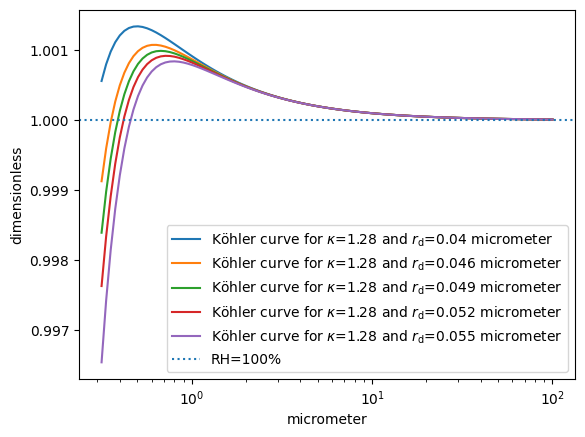

In [7]:
from matplotlib import pyplot

with DimensionalAnalysis():
    c, SI = constants()
    SI.setup_matplotlib()
    for rd in c.r_d[::n_sd//5]:
        pyplot.semilogx(
            rw := np.logspace(-.5, 2, 100) * SI.um,
            formulae.RH_eq(c, rw=rw, rd=rd),
            label=f"Köhler curve for $κ$={c.κ} and $r_\\text{{d}}$={rd.to(SI.um):.2g}"
        )
    pyplot.axhline(1, label="RH=100%", linestyle=':')
    pyplot.legend()

In [8]:
import numba
jit_compile = numba.jit(error_model='numpy', fastmath=True)

In [9]:
jf = make_namedtuple("J", {k: jit_compile(v) for k, v in formulae._asdict().items()})

@jit_compile
def ode_rhs(z, y, c):
    rhod = jf.rhod(c, pd=y[ix.pd], T=y[ix.T])
    rho_vs = jf.rhov(c, pv=jf.pvs(c, y[ix.T]), T=y[ix.T])
    rw = np.exp(y[ix.ln_rw])
    RH = jf.RH(c, rw3=rw**3, rho_vs=rho_vs, rhod=rhod)
    RH_eq = jf.RH_eq(c, rw=rw, rd=c.r_d)
    
    dy_dt = np.empty_like(y)
    dy_dt[ix.pd] = jf.dpd_dt(c, rhod=rhod)
    for i in range(ix.ln_rw.start, ix.ln_rw.stop):
        dy_dt[ix.ln_rw] = jf.dr_dt(c, rw=rw, rho_v=RH * rho_vs, rho_o=RH_eq * rho_vs) / rw
    dy_dt[ix.T] = jf.dT_dt(c, dpd_dt=dy_dt[ix.pd], dqv_dt=jf.dqv_dt(c, rw=rw, drw_dt=dy_dt[ix.ln_rw] * rw), rhod=rhod)
    return dy_dt

In [10]:
c, SI = constants()
solution = scipy.integrate.solve_ivp(
    ode_rhs, 
    (0, c.t_max),
    c.y0,
    max_step=.5 * SI.s,
    args=(c,),
    method='LSODA',
)
assert solution.success, solution.message

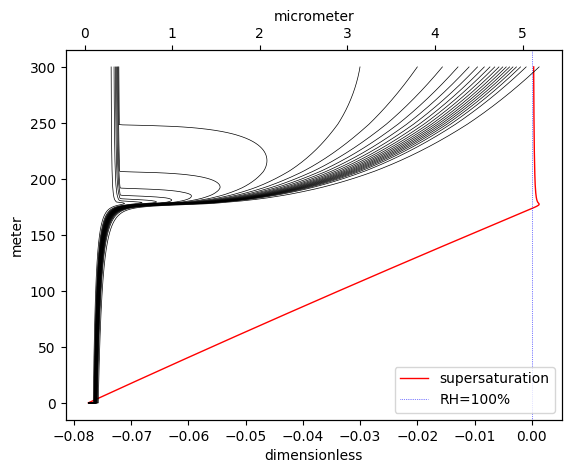

In [11]:
with DimensionalAnalysis():
    c, SI = constants()
    SI.setup_matplotlib()

    t = solution.t * SI.s
    pd = solution.y[ix.pd] * SI.Pa
    T = solution.y[ix.T] * SI.K
    rw = np.exp(solution.y[ix.ln_rw]) * SI.m
    RH = formulae.RH(c,
                     rw3=rw**3,
                     rho_vs=formulae.rhov(c, pv=formulae.pvs(c, T), T=T),
                     rhod=formulae.rhod(c, pd=pd, T=T)
                    )
    
    pyplot.plot(RH - 1, t * c.w, label="supersaturation", color='red', linewidth=1)
    pyplot.axvline(0, label="RH=100%", linestyle=':', color='blue', linewidth=.5)
    pyplot.legend(loc='lower right')
    
    twin = pyplot.gca().twiny()
    for i in range(ix.ln_rw.start, ix.ln_rw.stop):
        twin.plot(rw[i], t * c.w, color='k', linewidth=.5)
    twin.xaxis.set_units(SI.um)